In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
import config

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")
interm= os.join(root, "data", "2_intermediate")

plots= os.join(root, "code", "plots")

In [2]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [3]:
# files in clean data google drive
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


In [4]:
# load codebook        
codebk = drive.CreateFile({'id': '1Lf7kV9_R-caFZV6_l8hMxAVjFSVFhvYl'})
codebk.GetContentFile('codebook.xlsx')  

codebk= pd.read_excel('codebook.xlsx', sheet_name = "predictors")
codebk.head()

C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variable,Description,Source,Notes,Include_BBL,Include_Box
0,geofips,census tract geo identifier,Census ACS,NaN,0.0,0.0
1,geofips_recode,"census tract geo identifier, changes county to...",Census ACS,NaN,0.0,0.0
2,totpop,total population,Census ACS,NaN,1.0,1.0
3,popdens,total population per square mile,Census ACS,NaN,1.0,1.0
4,areasqmile,area,Census ACS,NaN,1.0,1.0


In [5]:
predictors_full = codebk.loc[codebk["Include_BBL"] == 1, "Variable"].apply(lambda x: x.strip())
predictors_full

2             totpop
3            popdens
4         areasqmile
5              males
6            females
           ...      
102        assesstot
103        exempttot
104        yearbuilt
105      landuse_cat
106    bldgclass_cat
Name: Variable, Length: 90, dtype: object

## Load building level analysis file

In [6]:
df_bbl = drive.CreateFile({'id': '1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G'})
df_bbl.GetContentFile('analysis_bbl.csv')  

df_bbl= pd.read_csv('analysis_bbl.csv').drop(["Unnamed: 0"], axis = 1)
df_bbl.head()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,bldgclass_A0,bldgclass_A6,bldgclass_A8,bldgclass_CM,bbl,boroct2010,vacate_ind,borough,landuse,bldgclass
0,2013.0,5555.0,1.0,4.0,6.0,6.0,345150.0,1317150.0,0.0,1899.0,...,0.0,0.0,0.0,0.0,1012090027,1018100,0.0,MN,2.0,C2
1,2517.0,6895.0,1.0,4.0,10.0,10.0,427500.0,1244700.0,0.0,1891.0,...,0.0,0.0,0.0,0.0,1012090028,1018100,0.0,MN,2.0,C5
2,10570.0,127289.0,1.0,17.0,69.0,69.0,2616300.0,12195900.0,136178.0,1930.0,...,0.0,0.0,0.0,0.0,1012090037,1018100,0.0,MN,3.0,D4
3,3926.0,20358.0,1.0,6.0,25.0,25.0,490500.0,1929600.0,92325.0,1961.0,...,0.0,0.0,0.0,0.0,1012090049,1018100,0.0,MN,3.0,D4
4,5035.0,21258.0,1.0,6.0,12.0,12.0,585000.0,1414350.0,15640.0,1905.0,...,0.0,0.0,0.0,0.0,1012090051,1018100,0.0,MN,3.0,D4


In [7]:
assert df_bbl["bbl"].isna().sum() == 0
assert df_bbl["holc_D"].isna().sum() == 0

In [8]:
assert df_bbl.loc[:, "vacate_ind"].isna().sum() == 0

In [9]:
print(df_bbl.columns)
df_bbl.describe()

Index(['lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'assessland', 'assesstot', 'exempttot', 'yearbuilt',
       ...
       'bldgclass_A0', 'bldgclass_A6', 'bldgclass_A8', 'bldgclass_CM', 'bbl',
       'boroct2010', 'vacate_ind', 'borough', 'landuse', 'bldgclass'],
      dtype='object', length=160)


,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,bldgclass_Z0,bldgclass_A2,bldgclass_A0,bldgclass_A6,bldgclass_A8,bldgclass_CM,bbl,boroct2010,vacate_ind,landuse
count,7.650260e+05,7.650260e+05,765026.000000,765026.000000,765026.000000,765026.000000,7.650260e+05,7.650260e+05,7.650260e+05,765026.000000,...,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,7.650260e+05,7.650260e+05,765026.000000,765026.000000
mean,3.812014e+03,5.051030e+03,1.324975,2.443933,4.689669,4.894059,5.407344e+04,2.821186e+05,5.387875e+04,1938.547234,...,0.000508,0.058912,0.011311,0.001029,0.000038,0.000001,3.548735e+09,3.541768e+06,0.003404,1.421477
std,2.318736e+04,3.520154e+04,2.726640,1.676083,42.058995,47.000007,5.127009e+05,2.549800e+06,1.355497e+06,68.722810,...,0.022544,0.235460,0.105749,0.032057,0.006157,0.001143,1.003515e+09,9.994487e+05,0.058243,0.842764
min,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000070e+09,1.000201e+06,0.000000,1.000000
25%,2.000000e+03,1.440000e+03,1.000000,2.000000,1.000000,1.000000,1.020000e+04,3.786000e+04,0.000000e+00,1920.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.036730e+09,3.030100e+06,0.000000,1.000000
50%,2.500000e+03,2.020000e+03,1.000000,2.000000,2.000000,2.000000,1.368000e+04,5.172000e+04,0.000000e+00,1931.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.012680e+09,4.010200e+06,0.000000,1.000000
75%,4.000000e+03,2.923000e+03,2.000000,2.750000,2.000000,2.000000,1.986000e+04,8.304000e+04,1.440000e+03,1960.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.107290e+09,4.092200e+06,0.000000,2.000000
max,1.225343e+07,1.354011e+07,1807.000000,98.000000,19201.000000,19203.000000,1.345064e+08,6.899244e+08,4.435560e+08,2021.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.080500e+09,5.032300e+06,1.000000,4.000000


In [10]:
df_bbl= pd.get_dummies(df_bbl, columns=["borough"])
borocols= ["borough_" + x for x in ["BK", "BX", "MN", "QN", "SI"]]

In [11]:
df_bbl.loc[:, predictors_full].head()

,totpop,popdens,areasqmile,males,females,pop18under,pop18_34,pop35_64,pop65plus,pophispanic,...,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,landuse_cat,bldgclass_cat
0,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,4.0,6.0,6.0,345150.0,1317150.0,0.0,1899.0,2.0,0
1,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,4.0,10.0,10.0,427500.0,1244700.0,0.0,1891.0,2.0,1
2,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,17.0,69.0,69.0,2616300.0,12195900.0,136178.0,1930.0,3.0,2
3,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,6.0,25.0,25.0,490500.0,1929600.0,92325.0,1961.0,3.0,2
4,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,6.0,12.0,12.0,585000.0,1414350.0,15640.0,1905.0,3.0,2


In [12]:
outcomes= ["vacate_ind"]
df_bbl[outcomes].head()

# very small percentage of the data has had a fire
df_bbl[outcomes[0]].mean()

0.003403805883721599

### Running LASSO to determine important variables

In [122]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df_bbl.loc[:, predictors_full])
X_scaled = scaler.transform(df_bbl.loc[:, predictors_full])

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_scaled, df_bbl.loc[:, outcomes], 
                                                            test_size=0.3, random_state=999)

In [123]:
coef_comp= pd.DataFrame(predictors_full).rename({'Variable': 'Features'}, axis = 1)
coef_comp

,Features
2,totpop
3,popdens
4,areasqmile
5,males
6,females
...,...
102,assesstot
103,exempttot
104,yearbuilt
105,landuse_cat


In [14]:
from sklearn import linear_model

param_grid= {'alpha':[0.00001, 0.0001, 0.0005, 0.0008, 0.0001]}
clf= linear_model.Lasso(fit_intercept = True)
gr = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)
rs = gr.fit(X_train_l, y_train_l)

print(rs.best_params_)
print(rs.best_score_)

{'alpha': 0.0005}
0.08153795512895834


In [124]:
clf= linear_model.Lasso(fit_intercept = True, alpha = 0.0005) #rs.best_params_['alpha'])
clf.fit(X_train_l, y_train_l)
coef_comp['coef_alpha_0.0005']= clf.coef_

In [125]:
clf= linear_model.Lasso(fit_intercept = True, alpha = 0.001)
clf.fit(X_train_l, y_train_l)
coef_comp['coef_alpha_0.001']= clf.coef_

In [126]:
# feature selection from LASSOs
# fewer features chosen
lasso_coef= coef_comp.loc[coef_comp['coef_alpha_0.0005'] != 0].sort_values('coef_alpha_0.0005', ascending = False)
print(lasso_coef.shape)
print(lasso_coef.loc[lasso_coef["coef_alpha_0.001"] != 0].shape)
lasso_coef

(11, 3)
(9, 3)


,Features,coef_alpha_0.0005,coef_alpha_0.001
86,hpd_b_c_vio,0.011581,0.008886
85,hpd_fire_vio,0.002446,0.002137
105,landuse_cat,0.000865,0.000503
3,popdens,0.000551,0.000451
99,unitsres,0.000547,0.000379
55,pcthoilker,0.000412,0.000132
96,bldgarea,0.000361,0.000134
11,pophispanic,0.000057,0.000000
34,medianhhincome,-0.000416,-0.000000
89,hpd_b_c_vio_per_unit,-0.001037,-0.000030


In [127]:
lasso_coef.to_csv(os.join(interm, "lasso_vars.csv"))

# (1) Decision Trees and Random Forest Models

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

X = df_bbl.loc[:, predictors_full].fillna(0)
y = df_bbl.loc[:, "vacate_ind"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)

# accuracy is very high, but that is bc most are 0s!
accuracy= (y_predict == y_test).value_counts(normalize=True)[True]
accuracy

0.9962789968105686

__Area under the curve__

In [20]:
dt=DecisionTreeClassifier(random_state = 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)

0.5702453545294232

In [21]:
# vs. random chance (only slightly better)
pred=np.random.random(len(X_test))
roc_auc_score(np.array(y_test.apply(int)),pred)

0.48266909628001886

## Tuning

In [130]:
# tune using the param grid
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train,y_train)
pred= rs.predict(X_test)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 5}
ROC AUC: 0.9727776630973826
Precision: 0.6666666666666666
Recall: 0.02806122448979592


In [54]:
# tune using the param grid
# optimize over the f1 score which is the tradeoff between precision and recall
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='f1')
rs=gr.fit(X_train,y_train)
pred= rs.predict(X_test)
print(rs.best_params_)

## look at precision and recall rates
precision_recall_fscore_support(y_test, pred)

{'max_depth': 19}


(array([0.99687807, 0.14285714]),
 array([0.99818996, 0.0880102 ]),
 array([0.99753358, 0.10891871]),
 array([228724,    784], dtype=int64))

In [59]:
# also depict the ROC AUC
pred_prob= rs.predict_proba(X_test)[:,1]

print(roc_auc_score(np.array(y_test),pred_prob))

0.8318268872491897


In [61]:
dt=DecisionTreeClassifier(max_depth = rs.best_params_['max_depth'], random_state= 99)
dt.fit(X_train,y_train)
pred_prob= dt.predict_proba(X_test)[:,1]

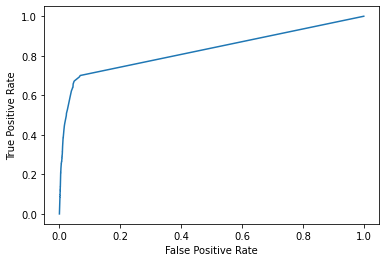

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, pred_prob, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

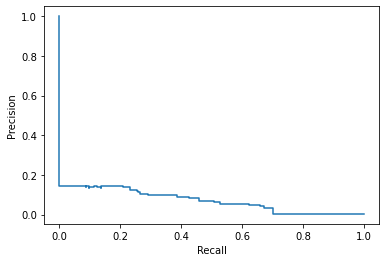

In [63]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, pred_prob, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

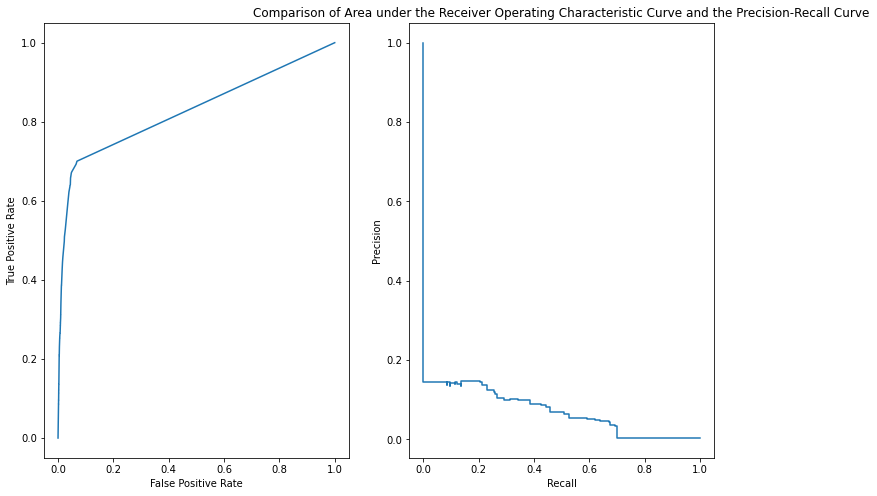

In [64]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.title("Comparison of Area under the Receiver Operating Characteristic Curve and the Precision-Recall Curve")
plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall.png'))

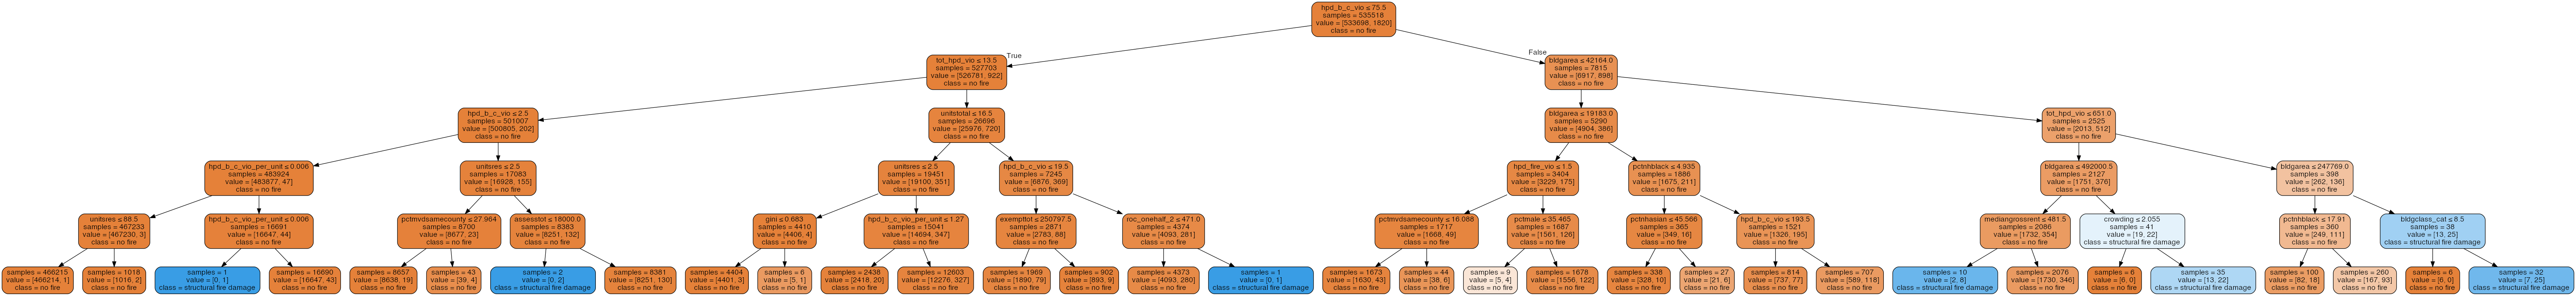

In [65]:
from sklearn import tree
from IPython.display import Image  
import pydotplus

# visualize the tree
dt = DecisionTreeClassifier(max_depth= 5)
dt.fit(X_train, y_train)

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no fire','structural fire damage'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_dt_bbl.png'))
Image(graph.create_png())

## Feature Importance

In [14]:
dt = DecisionTreeClassifier(max_depth= 5) #rs.best_params_['max_depth'])
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft.to_csv(os.join(interm, 'feature_importance_bbl.csv'))
ft

,variables,importance
69,hpd_b_c_vio,0.50554
79,bldgarea,0.208531
67,tot_hpd_vio,0.131449
83,unitstotal,0.027785
40,pctnhblack,0.021296
31,mediangrossrent,0.019428
89,bldgclass_cat,0.015009
82,unitsres,0.011738
48,crowding,0.009849
85,assesstot,0.009432


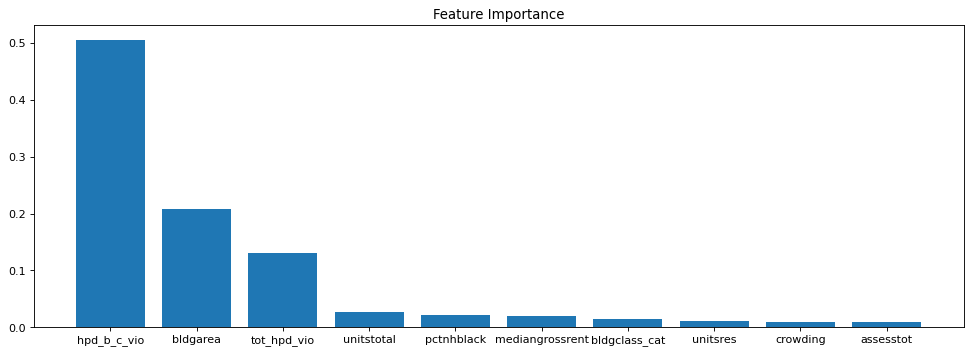

In [67]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,0],
        Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,1])
plt.title("Feature Importance");
plt.savefig(os.join(plots, 'feature_importance_bbl.png'))

## Random Forests

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_depth = 5)
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))

print("Precision and recall")
precision_recall_fscore_support(y_test, (pred > 0.5))

0.9760840777174093
Precision and recall


(array([0.99658834, 1.        ]),
 array([1.        , 0.00127551]),
 array([0.99829125, 0.00254777]),
 array([228724,    784], dtype=int64))

In [129]:
param_grid = {'max_depth':range(1,20)}
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 30)
gs = GridSearchCV(rf, param_grid=param_grid, scoring='roc_auc')
rs = gs.fit(X_train,y_train)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 9}
ROC AUC: 0.9773834196700488
Precision: 0.7272727272727273
Recall: 0.01020408163265306


In [134]:
param_grid = {'max_depth':range(1,20)}
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 30)
gs = GridSearchCV(rf, param_grid=param_grid, scoring='f1')
rs = gs.fit(X_train,y_train)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 18}
ROC AUC: 0.9702879633648112
Precision: 0.46153846153846156
Recall: 0.02295918367346939


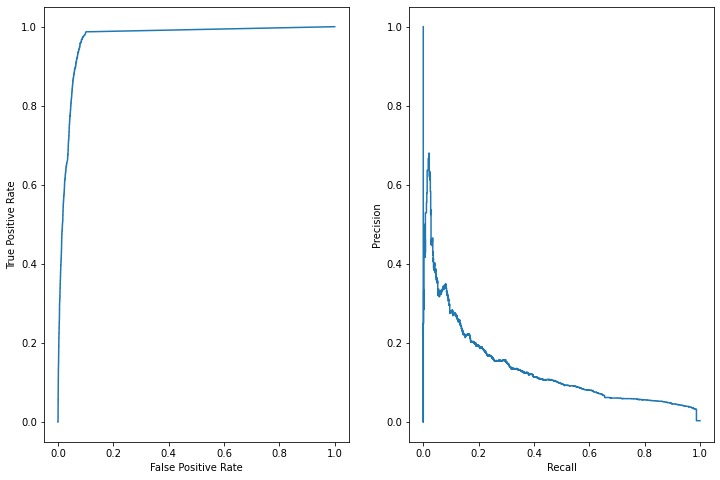

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)

plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall2.png'))

### CMM and other ensembles

In [72]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = rs.best_params_['max_depth'])
rf.fit(X_train,y_train)

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.25*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [73]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([pd.DataFrame(y_rand), y_train], axis = 0, ignore_index = True)

In [84]:
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train_cmm,y_train_cmm)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 4}
ROC AUC: 0.9755496130440073
Precision: 0.6153846153846154
Recall: 0.01020408163265306


In [74]:
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='f1')
rs=gr.fit(X_train_cmm,y_train_cmm)
pred= rs.predict(X_test)
print(rs.best_params_)
print(precision_recall_fscore_support(y_test, pred))
print(roc_auc_score(np.array(y_test),rs.predict_proba(X_test)[:,1]))

{'max_depth': 18}
(array([0.99685606, 0.12903226]), array([0.99811126, 0.08163265]), array([0.99748327, 0.1       ]), array([228724,    784], dtype=int64))
0.7898470683765014


In [76]:
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

ROC AUC: 0.7898470683765014
Precision: 0.12903225806451613
Recall: 0.08163265306122448


In [96]:
dt = DecisionTreeClassifier(max_depth= 5) # choose value for visualizing
dt.fit(X_train_cmm, y_train_cmm)

Feature_importance=pd.DataFrame([list(X_train_cmm.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft2= Feature_importance.sort_values(by="importance",ascending=False)
#ft2.to_csv(os.join(interm, 'feature_importance_bbl2.csv'))
ft2.loc[ft2['importance']>0]

,variables,importance
69,hpd_b_c_vio,0.495041
79,bldgarea,0.289217
67,tot_hpd_vio,0.061563
68,hpd_fire_vio,0.030151
31,mediangrossrent,0.028157
40,pctnhblack,0.02467
82,unitsres,0.019765
53,pcthoilker,0.01902
48,crowding,0.010023
78,lotarea,0.00534


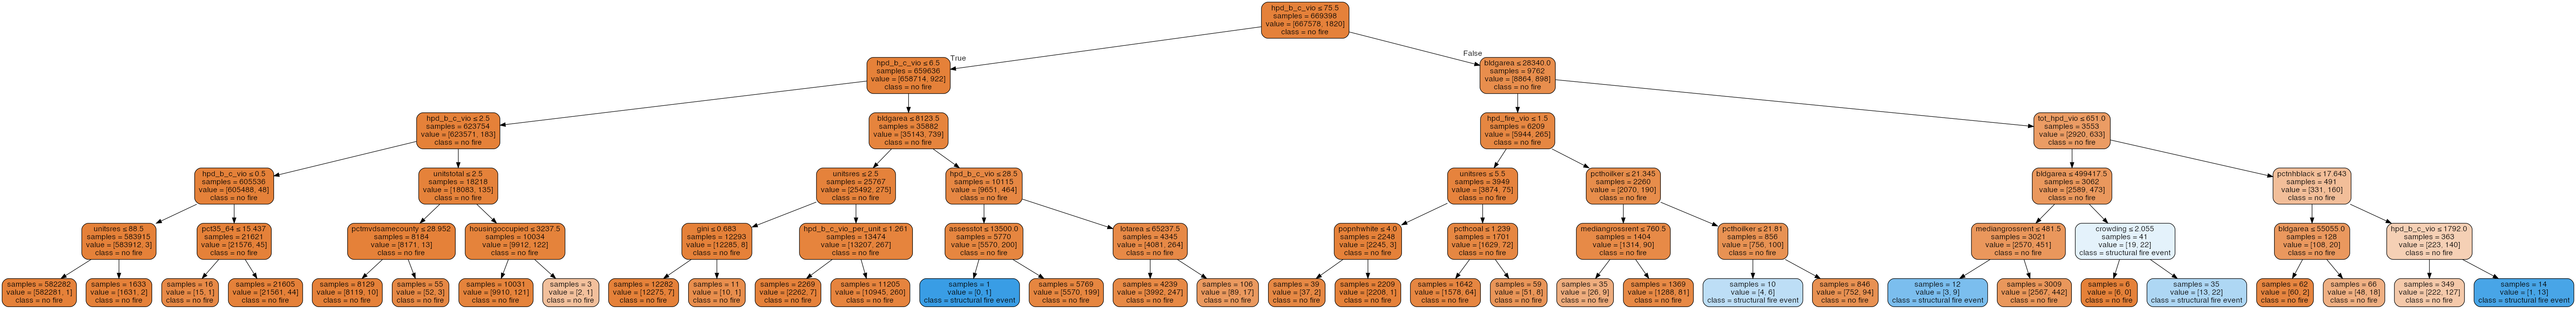

In [97]:
thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no fire','structural fire event'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_bbl_cmm.png'))
Image(graph.create_png())

## (2) Bayes Nets

In [15]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt

In [29]:
impt_vars= ['vacate_ind'] + ft.loc[ft['importance']>0, "variables"].tolist()
# use landuse instead since bldgclass has many values
impt_vars= [x if x != 'bldgclass_cat' else 'landuse_cat'  for x in impt_vars]
impt_vars

['vacate_ind',
 'hpd_b_c_vio',
 'bldgarea',
 'tot_hpd_vio',
 'unitstotal',
 'pctnhblack',
 'mediangrossrent',
 'landuse_cat',
 'unitsres',
 'crowding',
 'assesstot']

vacate_ind
hpd_b_c_vio


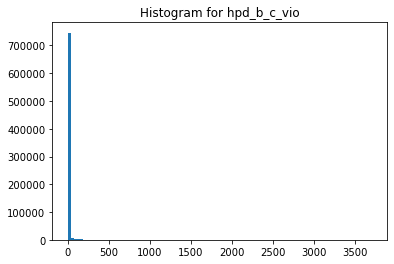

None
bldgarea


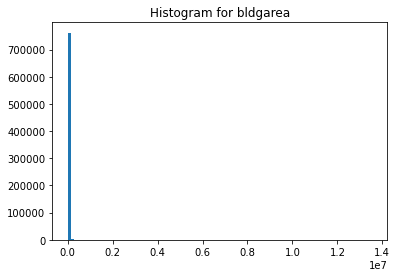

None
tot_hpd_vio


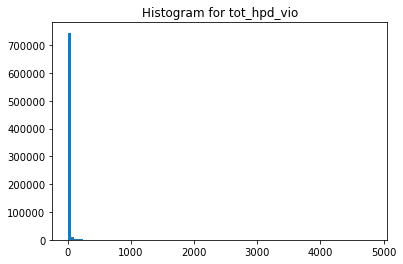

None
unitstotal


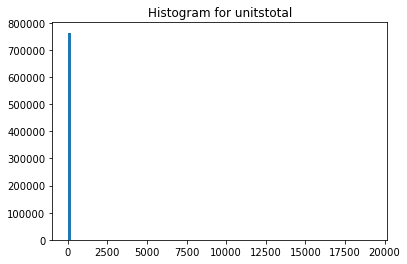

None
pctnhblack


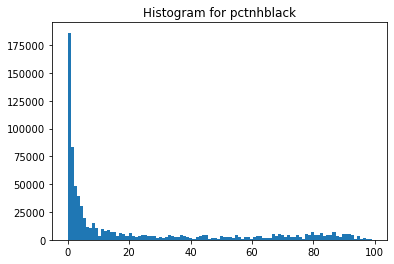

None
mediangrossrent


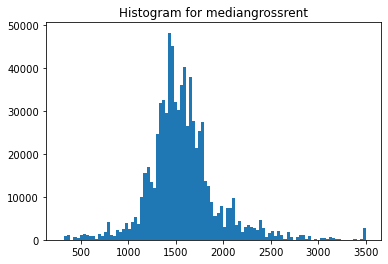

None
landuse_cat
unitsres


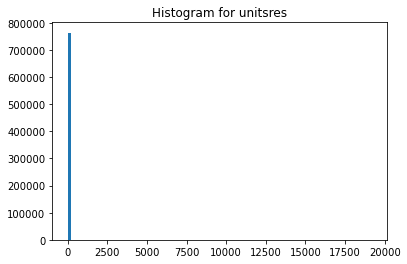

None
crowding


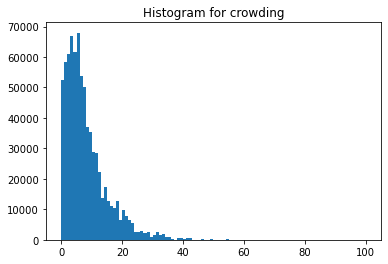

None
assesstot


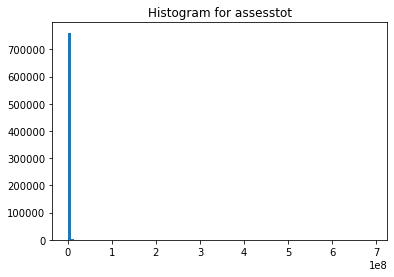

None


In [30]:
df_bbl_disc= df_bbl.loc[:, impt_vars].copy()
# need to discretize the data, also look at distributions
for i in impt_vars:
    print(i)
    if len(df_bbl_disc.loc[:, i].unique()) > 5:
        plt.hist(df_bbl_disc.loc[:, i], bins = 100);
        plt.title("Histogram for {}".format(i))
        print(plt.show())
        df_bbl_disc.loc[:, i] = pd.qcut(df_bbl_disc.loc[:, i], q=4, labels=False, duplicates = 'drop')

In [31]:
# create test train split for testing DAG
train, test = train_test_split(df_bbl_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [32]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('bldgarea', 'assesstot'), ('bldgarea', 'pctnhblack'), ('bldgarea', 'crowding'), ('bldgarea', 'landuse_cat'), ('bldgarea', 'mediangrossrent'), ('unitstotal', 'unitsres'), ('unitstotal', 'landuse_cat'), ('unitstotal', 'bldgarea'), ('unitstotal', 'crowding'), ('unitstotal', 'pctnhblack'), ('pctnhblack', 'assesstot'), ('pctnhblack', 'crowding'), ('mediangrossrent', 'crowding'), ('mediangrossrent', 'assesstot'), ('mediangrossrent', 'pctnhblack'), ('mediangrossrent', 'vacate_ind'), ('landuse_cat', 'vacate_ind'), ('unitsres', 'landuse_cat'), ('unitsres', 'assesstot'), ('unitsres', 'mediangrossrent'), ('unitsres', 'bldgarea'), ('unitsres', 'vacate_ind'), ('assesstot', 'crowding'), ('assesstot', 'landuse_cat')]


In [33]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['vacate_ind', 'hpd_b_c_vio', 'bldgarea', 'tot_hpd_vio', 'unitstotal', 'pctnhblack', 'mediangrossrent', 'landuse_cat', 'unitsres', 'crowding', 'assesstot']


In [34]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of bldgarea:
+-------------+----------------------+-----+---------------+---------------+----------------------+
| unitsres    | unitsres(0)          | ... | unitsres(2)   | unitsres(2)   | unitsres(2)          |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| unitstotal  | unitstotal(0)        | ... | unitstotal(0) | unitstotal(1) | unitstotal(2)        |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| bldgarea(0) | 0.5197432645587381   | ... | 0.25          | 0.25          | 0.004937779962191407 |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| bldgarea(1) | 0.30757176725754654  | ... | 0.25          | 0.25          | 0.03575915161022268  |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| bldgarea(2) | 0.1206841344505492   | ... | 0.25          | 0.25          | 0.2055

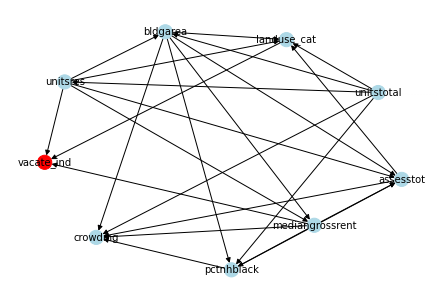

<Figure size 864x720 with 0 Axes>

In [35]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['vacate_ind'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('dag_bbl.png')

In [37]:
pred = model.predict(test.loc[:, ['pctnhblack', 'bldgarea','mediangrossrent', 'crowding',
                                  'unitsres', 'unitstotal', 'assesstot', 'landuse_cat']],
                    stochastic = True)
print(pred)

  0%|          | 0/4157 [00:00<?, ?it/s]

        vacate_ind
596255         0.0
695748         0.0
701775         0.0
222295         0.0
79883          0.0
...            ...
708711         0.0
577957         0.0
667376         0.0
400735         0.0
685689         0.0

[229508 rows x 1 columns]


In [38]:
# calc out of sample accuracy
print("\nOS accuracy for vacate orders")
print((pred['vacate_ind'].reset_index(drop = True) == test['vacate_ind'].reset_index(drop = True)).mean())

print("\nOS precision and recall for vacate orders")
pre_rec= precision_recall_fscore_support(np.asarray(test['vacate_ind']), 
                                      np.asarray(pred['vacate_ind']))

print("Precision:", pre_rec[0][1])
print("Recall:", pre_rec[1][1])


OS accuracy for vacate orders
0.9932812799553828

OS precision and recall for vacate orders
Precision: 0.03094059405940594
Recall: 0.03188775510204082


# Anomaly Detection

## Isolation forests

In [109]:
from sklearn.ensemble import IsolationForest

# generate outliers
X_outliers= X.loc[X.loc[y==1].index, :]
X_reg= X.loc[X.loc[y==0].index, :]
# generate test and train data
X_train, X_test= train_test_split(X_reg, test_size=0.3, random_state=999)

# fit the model
if_clf = IsolationForest(max_samples=100, random_state=99)
if_clf.fit(X_train)
y_pred_train = if_clf.predict(X_train)
y_pred_test = if_clf.predict(X_test)
y_pred_outliers = if_clf.predict(X_outliers)

In [110]:
print("Percent training classified as inliers:", np.mean(y_pred_train==1))
print("Percent test data classified as inliers:", np.mean(y_pred_test==1))
print("Percent outliers classified as inliers:", np.mean(y_pred_outliers==1))

Percent training classified as inliers: 0.9160100806640497
Percent test data classified as inliers: 0.9156286752329196
Percent outliers classified as inliers: 0.23809523809523808


In [150]:
# OS accuracy
print("OS accuracy:", np.mean(np.append(y_pred_test, y_pred_outliers)== np.append(np.repeat(1, len(y_pred_test)), np.repeat(-1, len(y_pred_outliers)))))
# low precision and recall (esp. compared to random forest)
print("\nOS precision and recall for isolation tree")
pre_rec= precision_recall_fscore_support(np.append(y_pred_test, y_pred_outliers)==-1,
                                      np.append(np.repeat(1, len(y_pred_test)), np.repeat(-1, len(y_pred_outliers)))==-1)

print("Precision:", pre_rec[0][1])
print("Recall:", pre_rec[1][1])

OS accuracy: 0.9138982669854019

OS precision and recall for isolation tree
Precision: 0.7619047619047619
Recall: 0.0932243210224603
